In [42]:
#NETWORKX / JSON / DATAFRAME / ADJMX / METRICS+SCATTER / VIZ+GEPHI

In [43]:
%pylab inline
import numpy as np
import pandas as pd
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


# NetworkX

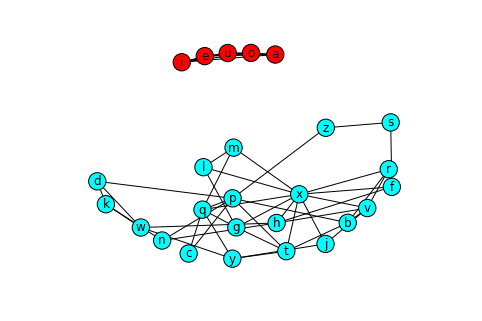

In [44]:
#create
demo = nx.Graph() #qui crea un grafo vuoto e sta usando un dataset dummy

consonants = list(set("bcdfghjklmnpqrstvwxyz"))
vowels = list(set("aeiou"))

#add nodes
for c in consonants:
    demo.add_node(c) #aggiunge dei nodi per ciascuna lettera
for v in vowels:
    demo.add_node(v) 
    
#add random edges
for i in range(50): #qua aggiunge delle connessioni
    demo.add_edge(numpy.random.choice(consonants),numpy.random.choice(consonants))
for i in range(100):
    demo.add_edge(numpy.random.choice(vowels),numpy.random.choice(vowels))

#draw
nx.draw(demo, with_labels=True, node_color=['red' if i in set('aeiou') else 'cyan' for i in demo.nodes_iter()]) #e' il comando per scrivere il draw

# come genero grafi

* creo un grafo demo = nx.Graph() 
* aggiungo i nodi demo.add_node(c)
* e poi aggiungo i link tramite il medoto addedge

In [45]:
print 'connected components',[cc for cc in nx.connected_components(demo)] #Componenti connesse - due gruppi vocali e consonanti
print
print 'degrees',np.array(nx.degree(demo)) # il grado dei nodi -> viene tornato il dizionario
print
print 'clustering_coefficients',np.array(nx.clustering(demo)) # coefficiente di clustering
print
print 'diameter_vowels:',nx.diameter(demo.subgraph(vowels)),'- dimameter_consonant:',nx.diameter(demo.subgraph(consonants)) # e' il massimo numero di passi per andare da un punto all'altro del grafo

connected components [set(['a', 'i', 'u', 'e', 'o']), set(['c', 'b', 'd', 'g', 'f', 'h', 'k', 'j', 'm', 'l', 'n', 'q', 'p', 's', 'r', 't', 'w', 'v', 'y', 'x', 'z'])]

degrees {'a': 6, 'c': 2, 'b': 4, 'e': 6, 'd': 3, 'g': 4, 'f': 3, 'i': 6, 'h': 5, 'k': 3, 'j': 3, 'm': 3, 'l': 3, 'o': 6, 'n': 3, 'q': 6, 'p': 7, 's': 2, 'r': 5, 'u': 6, 't': 5, 'w': 4, 'v': 5, 'y': 4, 'x': 12, 'z': 2}

clustering_coefficients {'a': 1.0, 'c': 1.0, 'b': 0.3333333333333333, 'e': 1.0, 'd': 0.3333333333333333, 'g': 0.5, 'f': 0.3333333333333333, 'i': 1.0, 'h': 0.2, 'k': 0.3333333333333333, 'j': 0.3333333333333333, 'm': 0.6666666666666666, 'l': 0.6666666666666666, 'o': 1.0, 'n': 0.0, 'q': 0.2, 'p': 0.09523809523809523, 's': 0.0, 'r': 0.6666666666666666, 'u': 1.0, 't': 0.2, 'w': 0.16666666666666666, 'v': 0.4, 'y': 0.0, 'x': 0.2, 'z': 0.0}

diameter_vowels: 1 - dimameter_consonant: 4


# Data Import

In [46]:
#get data, as jsons, from http://bank.top-ix.org/banks

In [47]:
import urllib2
import json
request = urllib2.urlopen('http://bank.top-ix.org/banks') #i dati che ci interessano sono in questo dataset con le banche
data = json.loads(request.read())
#connect
index = [(entry['BANK_ID'],entry['BANK']) for entry in data['data']] #variabile che si chiama index
payload = json.loads(urllib2.urlopen('http://bank.top-ix.org/data/'+str(index[0][0])).read()) #qui si vede l'informazione relativa alla banca
#init dataframe
fields = np.array(payload['data'][0].keys())
data = pd.DataFrame({i:[] for i in range(6)})
data.columns = fields
data

,GDP_2012_EURO,BANK_COUNTRY,MILLIONS_EUROS,EXPOSURE_COUNTRY,COUNTRY_EXPOSURE,BANK


In [37]:
index

[(0, u'Erste Group Bank AG'),
 (1, u'Raiffeisen Zentralbank \xd6sterreich AG'),
 (2, u'KBC BANK'),
 (3, u'CYPRUS POPULAR BANK PUBLIC CO LTD'),
 (4, u'BANK OF CYPRUS PUBLIC CO LTD'),
 (5, u'DEUTSCHE BANK AG'),
 (6, u'COMMERZBANK AG'),
 (7, u'Landesbank Baden-W\xfcrttemberg'),
 (8, u'DZ BANK AG Dt. Zentral-Genossenschaftsbank'),
 (9, u'Bayerische Landesbank'),
 (10, u'Norddeutsche Landesbank -GZ'),
 (11, u'Hypo Real Estate Holding AG, M\xfcnchen'),
 (12, u'HSH Nordbank AG, Hamburg'),
 (13, u'Landesbank Hessen-Th\xfcringen GZ, Frankfurt'),
 (14, u'Landesbank Berlin AG'),
 (15, u'DekaBank Deutsche Girozentrale, Frankfurt'),
 (16, u'WGZ BANK AG Westdt. Geno. Zentralbk, Ddf'),
 (17, u'DANSKE BANK'),
 (18, u'Jyske Bank'),
 (19, u'Sydbank'),
 (20, u'Nykredit'),
 (21, u'BANCO SANTANDER S.A.'),
 (22, u'BANCO BILBAO VIZCAYA ARGENTARIA S.A. (BBVA)'),
 (23, u'CAJA DE AHORROS Y PENSIONES DE BARCELONA'),
 (24, u'BANCO POPULAR ESPA\xd1OL, S.A.'),
 (25, u'OP-Pohjola Group'),
 (26, u'BNP PARIBAS'),
 (27

* Voglio portare le stesse info in un unico dataframe *

In [38]:
#EX_1: fill in

#download data for each bank

#to append a row to a DF, do
#data.loc[len(data)] = np.array(element.values())

import urllib2
import json

for eind,entry in enumerate(index):
    request = urllib2.urlopen('http://bank.top-ix.org/data/'+ str(entry[0])) # ho messo 60 per fare le prove
    data = json.loads(request.read())
    print 'loaded ' , eind+1 , ' of ' , len(index), ' : ' , data['bank']['BANK']
          #print (data)

        
    #values = np.array(data['data'])
    #bank = np.array(data['bank']['BANK'])
    #listvalue=[]

    #for value in values :
    #    for data in value:
    #        listvalue.append(value[data])
    #        print(value[data])

            
            
#''' data.loc[len(data)] = np.array(element.values())'''            
            
#print listvalue    
    
#bank  = np.array[]
#print(value)
#ba
#connect
#index = [(entry['BANK_ID'],entry['BANK']) for entry in data['data']] #variabile che si chiama index
#payload = json.loads(urllib2.urlopen('http://bank.top-ix.org/data/'+str(index[0][0])).read()) #qui si vede l'informazione relativa alla banca
#init dataframe
#fields = np.array(payload['data'][0].value())
#data = pd.DataFrame({i:[] for i in range(6)})
#data.columns = fields
#data

loaded  1  of  61  :  Erste Group Bank AG
loaded  2  of  61  :  Raiffeisen Zentralbank Österreich AG
loaded  3  of  61  :  KBC BANK
loaded  4  of  61  :  CYPRUS POPULAR BANK PUBLIC CO LTD
loaded  5  of  61  :  BANK OF CYPRUS PUBLIC CO LTD
loaded  6  of  61  :  DEUTSCHE BANK AG
loaded  7  of  61  :  COMMERZBANK AG
loaded  8  of  61  :  Landesbank Baden-Württemberg
loaded  9  of  61  :  DZ BANK AG Dt. Zentral-Genossenschaftsbank
loaded  10  of  61  :  Bayerische Landesbank
loaded  11  of  61  :  Norddeutsche Landesbank -GZ
loaded  12  of  61  :  Hypo Real Estate Holding AG, München
loaded  13  of  61  :  HSH Nordbank AG, Hamburg
loaded  14  of  61  :  Landesbank Hessen-Thüringen GZ, Frankfurt
loaded  15  of  61  :  Landesbank Berlin AG
loaded  16  of  61  :  DekaBank Deutsche Girozentrale, Frankfurt
loaded  17  of  61  :  WGZ BANK AG Westdt. Geno. Zentralbk, Ddf
loaded  18  of  61  :  DANSKE BANK
loaded  19  of  61  :  Jyske Bank
loaded  20  of  61  :  Sydbank
loaded  21  of  61  :  Nykr

In [48]:
#corretto da insegnante
#download data for each bank
for eind,entry in enumerate(index):
    payload = json.loads(urllib2.urlopen('http://bank.top-ix.org/data/'+str(entry[0])).read()) 
    print 'loaded',eind+1,'of',len(index),':',payload['bank']['BANK']
    for element in payload['data']:
       data.loc[len(data)] = np.array(element.values()) #il .loc serve per l'append

loaded 1 of 61 : Erste Group Bank AG
loaded 2 of 61 : Raiffeisen Zentralbank Österreich AG
loaded 3 of 61 : KBC BANK
loaded 4 of 61 : CYPRUS POPULAR BANK PUBLIC CO LTD
loaded 5 of 61 : BANK OF CYPRUS PUBLIC CO LTD
loaded 6 of 61 : DEUTSCHE BANK AG
loaded 7 of 61 : COMMERZBANK AG
loaded 8 of 61 : Landesbank Baden-Württemberg
loaded 9 of 61 : DZ BANK AG Dt. Zentral-Genossenschaftsbank
loaded 10 of 61 : Bayerische Landesbank
loaded 11 of 61 : Norddeutsche Landesbank -GZ
loaded 12 of 61 : Hypo Real Estate Holding AG, München
loaded 13 of 61 : HSH Nordbank AG, Hamburg
loaded 14 of 61 : Landesbank Hessen-Thüringen GZ, Frankfurt
loaded 15 of 61 : Landesbank Berlin AG
loaded 16 of 61 : DekaBank Deutsche Girozentrale, Frankfurt
loaded 17 of 61 : WGZ BANK AG Westdt. Geno. Zentralbk, Ddf
loaded 18 of 61 : DANSKE BANK
loaded 19 of 61 : Jyske Bank
loaded 20 of 61 : Sydbank
loaded 21 of 61 : Nykredit
loaded 22 of 61 : BANCO SANTANDER S.A.
loaded 23 of 61 : BANCO BILBAO VIZCAYA ARGENTARIA S.A. (BBVA)

In [49]:
data.columns = ['gdp','origin','millions','exposure','perc','bank'] #rinominato le colonne
rearrange_columns = ['bank','origin','exposure','gdp','millions','perc']
data = data[rearrange_columns]
data.head()

,bank,origin,exposure,gdp,millions,perc
0,Erste Group Bank AG,Austria,Austria,"309,900.90","9,150.23",28.27
1,Erste Group Bank AG,Austria,Belgium,"376,840.00",92.73,0.29
2,Erste Group Bank AG,Austria,Bulgaria,"39,667.70",1.76,0.01
3,Erste Group Bank AG,Austria,Cyprus,"17,886.80",0.00,0.00
4,Erste Group Bank AG,Austria,Czech Republic,"152,828.00","9,659.61",29.84


# Data Cleaning

In [50]:
#EX_2: poke around - any data cleaning?
data.head(40)


#eliminare le righe che hanno millions e perc 0 
data = data[data['millions']!='0.00'] #mi usa la maschera per togliere i dati a zero

#eliminare le righe con TOTAL EEA 
data = data[data['exposure']!='TOTAL EEA 30'] #data['exposure']!='TOTAL EEA 30' --> Questo mi estrae tutte le righe che non hanno exposure diverso da TOTAL EEA 30

#data[data['exposure']!='TOTAL EEA 30'] --> Questa e' l'applicazione della maschera


#fare diventare i importi in numeri aggiustando la notazione eliminando la virgola

#get rid of pesky commas in numbers
data['gdp'] = data['gdp'].astype('str').apply(lambda x : x.replace(',','')).astype('float')
data['millions'] = data['millions'].astype('str').apply(lambda x : x.replace(',','')).astype('float')


In [51]:
data.head(30)

,bank,origin,exposure,gdp,millions,perc
0,Erste Group Bank AG,Austria,Austria,309900.9,9150.23,28.27
1,Erste Group Bank AG,Austria,Belgium,376840.0,92.73,0.29
2,Erste Group Bank AG,Austria,Bulgaria,39667.7,1.76,0.01
4,Erste Group Bank AG,Austria,Czech Republic,152828.0,9659.61,29.84
5,Erste Group Bank AG,Austria,Denmark,244063.7,0.02,0.00
7,Erste Group Bank AG,Austria,Finland,194469.0,78.68,0.24
8,Erste Group Bank AG,Austria,France,2029877.4,106.22,0.33
9,Erste Group Bank AG,Austria,Germany,2643900.0,883.61,2.73
10,Erste Group Bank AG,Austria,Greece,193749.0,0.76,0.00
11,Erste Group Bank AG,Austria,Hungary,97756.3,1618.29,5.00


# Make DataFrames

In [70]:
#data:all, nndata:nation->nation, bdata:bipartite

In [71]:
print len(data)
data.head()

859


,bank,origin,exposure,gdp,millions,perc
0,Erste Group Bank AG,Austria,Austria,309900.9,9150.23,28.27
1,Erste Group Bank AG,Austria,Belgium,376840.0,92.73,0.29
2,Erste Group Bank AG,Austria,Bulgaria,39667.7,1.76,0.01
4,Erste Group Bank AG,Austria,Czech Republic,152828.0,9659.61,29.84
5,Erste Group Bank AG,Austria,Denmark,244063.7,0.02,0.00


In [72]:
nndata = pd.DataFrame(data.groupby(['origin','exposure'], as_index=False)['millions'].sum())
print len(nndata)
nndata.head()

347


,origin,exposure,millions
0,Austria,Austria,10081.94
1,Austria,Belgium,109.05
2,Austria,Bulgaria,325.87
3,Austria,Czech Republic,10649.44
4,Austria,Denmark,0.02


In [73]:
bdata = data[['bank','exposure','millions']]
print len(bdata)
bdata.head()

859


,bank,exposure,millions
0,Erste Group Bank AG,Austria,9150.23
1,Erste Group Bank AG,Belgium,92.73
2,Erste Group Bank AG,Bulgaria,1.76
4,Erste Group Bank AG,Czech Republic,9659.61
5,Erste Group Bank AG,Denmark,0.02


# Adjacency Matrices (nndata and bdata)

In [74]:
nations = sorted(pd.concat([data.origin, data.exposure]).unique())
banks = sorted(data.bank.unique())
print len(nations),'nations,',len(banks),'banks'

30 nations, 61 banks


In [75]:
print nations

[u'Austria', u'Belgium', u'Bulgaria', u'Cyprus', u'Czech Republic', u'Denmark', u'Estonia', u'Finland', u'France', u'Germany', u'Greece', u'Hungary', u'Iceland', u'Ireland', u'Italy', u'Latvia', u'Liechtenstein', u'Lithuania', u'Luxembourg', u'Malta', u'Netherlands', u'Norway', u'Poland', u'Portugal', u'Romania', u'Slovakia', u'Slovenia', u'Spain', u'Sweden', u'United Kingdom']


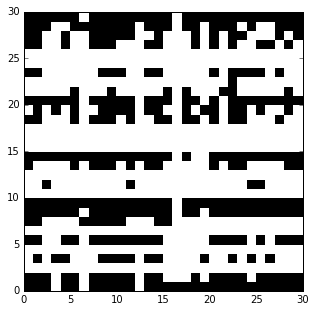

In [76]:
adjm_w_nn = np.zeros([len(nations),len(nations)])
adjm_b_nn = np.zeros([len(nations),len(nations)])
for i,ie in enumerate(nations):
    for j,je in enumerate(nations):
        if ie in np.array(nndata['origin']) and je in np.array(nndata[nndata['origin']==ie]['exposure']):
            adjm_w_nn[i,j]=nndata[(nndata['origin']==ie) & (nndata['exposure']==je)]['millions']
            adjm_b_nn[i,j]=1
           
figure(figsize=(5,5))
pcolormesh(adjm_b_nn, cmap=cm.binary)

 ### per bip mettere vicine entita' nella matrice di adiacenza che hanno caratteristiche simili cosi' da fare emergere eventuali cluster di punti 

[0, 30, 0, 61]

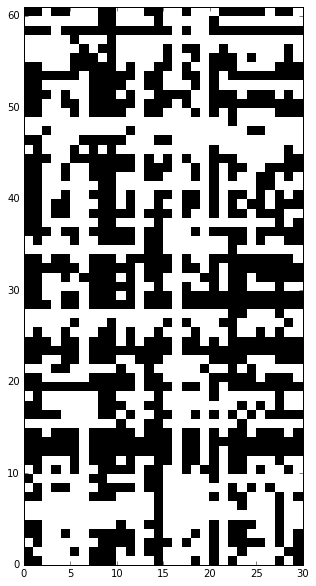

In [77]:
adjm_w_b = np.zeros([len(banks),len(nations)])
adjm_b_b = np.zeros([len(banks),len(nations)])
for i,ie in enumerate(banks):
    for j,je in enumerate(nations):
        if ie in np.array(bdata['bank']) and je in np.array(bdata[bdata['bank']==ie]['exposure']):
            adjm_w_b[i,j]=bdata[(bdata['bank']==ie) & (bdata['exposure']==je)]['millions']
            adjm_b_b[i,j]=1

figure(figsize=(5,10))
pcolormesh(adjm_b_b, cmap=cm.binary)
plt.axis([0, len(nations), 0, len(banks)])

In [78]:
#order is arbitrary

# Graph-Viz, part 1

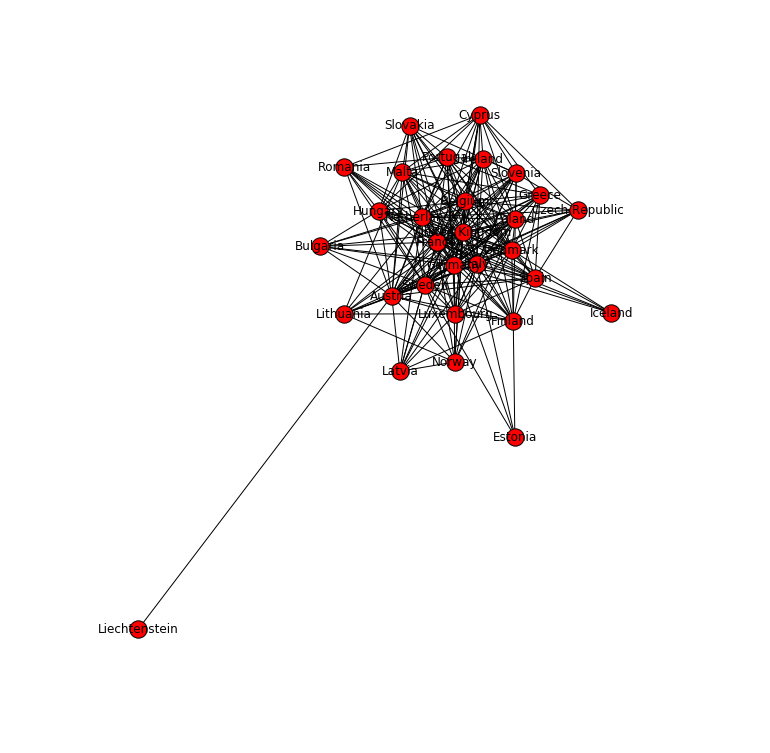

In [79]:
#building graph, edge by edge
Gnn = nx.Graph()
for i in range(adjm_b_nn.shape[0]):
    for j in range(adjm_b_nn.shape[1]):
        if adjm_b_nn[i,j]==1:
            Gnn.add_edge(nations[i],nations[j])
figure(figsize=(10,10))
nx.draw(Gnn,with_labels=True)

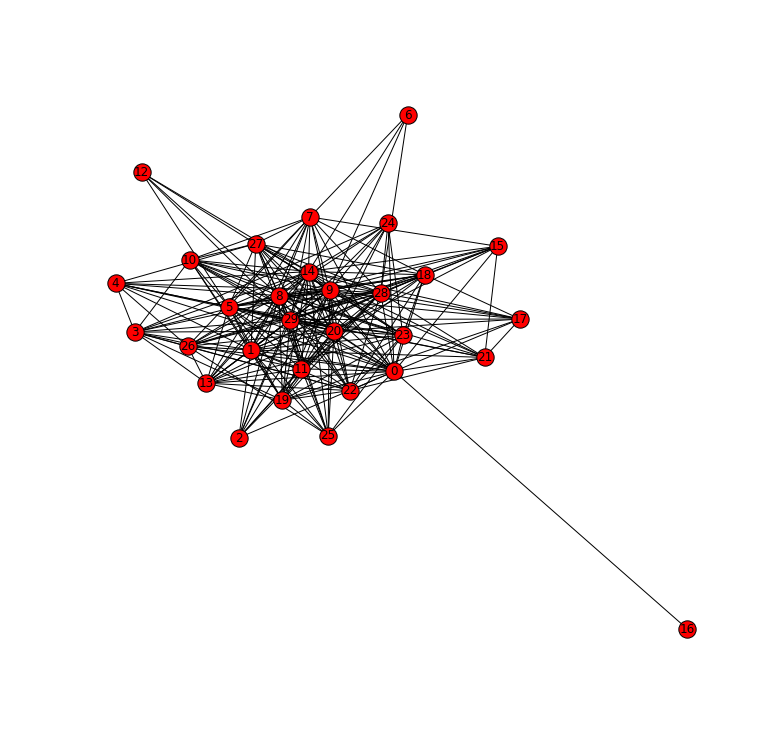

In [80]:
#the easy way
Gnn = nx.from_numpy_matrix(adjm_b_nn)
figure(figsize=(10,10))

nx.draw(Gnn,with_labels=True)

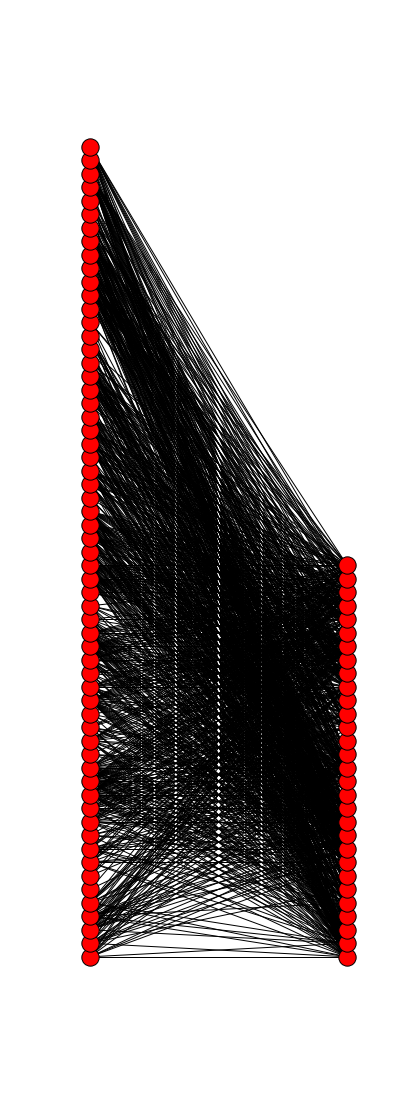

In [81]:
#and a bipartite graph

#building
from scipy.sparse import csr_matrix
from networkx.algorithms import bipartite
sparse_adj_matrix_b = csr_matrix(adjm_b_b)
Gb = bipartite.from_biadjacency_matrix(sparse_adj_matrix_b)

#drawing
figure(figsize=(5,15))
X, Y = bipartite.sets(Gb)
pos = dict()
pos.update((n, (0, i*10)) for i, n in enumerate(X))
pos.update((n, (0.5, i*10)) for i, n in enumerate(Y))
nx.draw(Gb, pos=pos)
plt.show()

In [82]:
#Awful, right? Visualisation is not necessarily enlightning 
#We'll see something nicer further on. For now we'll use the graphs to compute metrics

# Metrics

In [83]:
#EX_3: Matrics! What can you obtain by groupby? What by using nx methods? How can you viz the results?
# bdata = data[['bank','exposure','millions']]
#out-degree (nation-banche)
for name,group in data.groupby('exposure'):
    print name,len(group.groupby('bank')),

Austria 41 Belgium 46 Bulgaria 14 Cyprus 15 Czech Republic 27 Denmark 25 Estonia 8 Finland 36 France 48 Germany 51 Greece 28 Hungary 34 Iceland 6 Ireland 35 Italy 50 Latvia 25 Liechtenstein 1 Lithuania 26 Luxembourg 24 Malta 6 Netherlands 43 Norway 17 Poland 45 Portugal 34 Romania 23 Slovakia 28 Slovenia 23 Spain 39 Sweden 32 United Kingdom 29


In [84]:
#in-degree (nation-clustered)
for name,group in data.groupby('origin'):
    print name,len(group.groupby('exposure')),

Austria 27 Belgium 22 Cyprus 13 Denmark 20 Finland 9 France 27 Germany 29 Hungary 4 Ireland 13 Italy 27 Luxembourg 15 Malta 16 Netherlands 25 Norway 7 Poland 1 Portugal 13 Slovenia 14 Spain 15 Sweden 22 United Kingdom 28


In [85]:
#in-degree (bank-clustered)
for name,group in data.groupby('bank'):
    print name,len(group.groupby('exposure')),

ABN AMRO BANK NV 11 ALLIED IRISH BANKS PLC 12 BANCA MONTE DEI PASCHI DI SIENA S.p.A 16 BANCO BILBAO VIZCAYA ARGENTARIA S.A. (BBVA) 15 BANCO COMERCIAL PORTUGUÊS, SA (BCP OR MILLENNIUM BCP) 10 BANCO POPOLARE - S.C. 2 BANCO POPULAR ESPAÑOL, S.A. 3 BANCO SANTANDER S.A. 11 BANK OF CYPRUS PUBLIC CO LTD 12 BANK OF IRELAND 6 BANK OF VALLETTA (BOV) 16 BANQUE ET CAISSE D'EPARGNE DE L'ETAT 15 BARCLAYS plc 26 BNP PARIBAS 27 BPCE 22 Banco BPI, SA 4 Bayerische Landesbank 17 CAIXA GERAL DE DEPÓSITOS, SA 10 CAJA DE AHORROS Y PENSIONES DE BARCELONA 6 COMMERZBANK AG 26 CREDIT AGRICOLE 17 CYPRUS POPULAR BANK PUBLIC CO LTD 7 DANSKE BANK 17 DEUTSCHE BANK AG 28 DZ BANK AG Dt. Zentral-Genossenschaftsbank 23 DekaBank Deutsche Girozentrale, Frankfurt 10 DnB NOR Bank ASA 7 ESPÍRITO SANTO FINANCIAL GROUP, SA (ESFG) 3 Erste Group Bank AG 26 HSBC HOLDINGS plc 24 HSH Nordbank AG, Hamburg 13 Hypo Real Estate Holding AG, München 19 ING BANK NV 25 INTESA SANPAOLO S.p.A 22 IRISH LIFE AND PERMANENT 3 Jyske Bank 13 KBC B

In [86]:
exposure = sorted(data.exposure.unique())
banks = sorted(data.bank.unique())
print len(nations),'nations,',len(banks),'banks'

30 nations, 61 banks


[(u'Austria', 41), (u'Belgium', 37), (u'Bulgaria', 9), (u'Cyprus', 19), (u'Czech Republic', 11), (u'Denmark', 32), (u'Estonia', 4), (u'Finland', 22), (u'France', 43), (u'Germany', 46), (u'Greece', 14), (u'Hungary', 18), (u'Iceland', 5), (u'Ireland', 26), (u'Italy', 43), (u'Latvia', 10), (u'Liechtenstein', 1), (u'Lithuania', 10), (u'Luxembourg', 24), (u'Malta', 20), (u'Netherlands', 39), (u'Norway', 15), (u'Poland', 18), (u'Portugal', 25), (u'Romania', 10), (u'Slovakia', 12), (u'Slovenia', 22), (u'Spain', 26), (u'Sweden', 34), (u'United Kingdom', 38)]


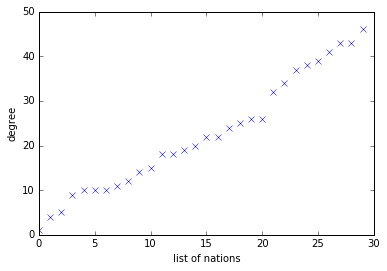

In [87]:
#degree_nn = in+out
degrees_nn = (adjm_b_nn.sum(axis=1)+adjm_b_nn.sum(axis=0)-np.diagonal(adjm_b_nn)).astype('int')

#fa la somma per riga sulla matrice di adiacenza e trova il grado uscente per nazione
#fa la somma per colonne sulla matrice di adiacenze e trova il grado entrante per nazione
print zip(nations,degrees_nn) #prente due liste e le associa elemento per elemento
plot(sorted(degrees_nn), 'bx')
xlabel('list of nations')
ylabel('degree')

In [146]:
banks = sorted(data.bank.unique())
nations = sorted(data.exposure.unique())

print 'nations', len(nations), 'banks', len(banks)

#my_adjm_w_nn = np.zeros([len(banks),len(nations)])
my_adjm_b_nn = np.zeros([len(banks),len(nations)])
for i,ie in enumerate(banks):
    print ie
    for j,je in enumerate(nations):
        #print 'nations ', je , 'bank ', ie
        #print (ie in np.array(data['bank']))
        print (np.array(data[data['bank']==ie]['exposure']))
        #if ie in np.array(data['bank']) & je in np.array(data[data['bank']==ie]['exposure']):
        #    my_adjm_b_nn[i,j]=1
            
        #if ie in np.array(data['bank']):
        #    print(data['bank'])
        #    adjm_w_nn[i,j]=data[(data['exposure'==ie] ) & (data[data['bank'==je]])]
        # if ie in np.array(data['origin']) and je in np.array(data[data['origin']==ie]['exposure']):
        #    adjm_w_nn[i,j]=data[(nndata['origin']==ie) & (data['exposure']==je)]['millions']
        #    adjm_b_nn[i,j]=1
           
#figure(figsize=(5,5)) pcolormesh(my_adjm_b_nn, cmap=cm.binary)

nations 30 banks 61
ABN AMRO BANK NV
[u'Austria' u'Belgium' u'Finland' u'France' u'Germany' u'Italy'
 u'Luxembourg' u'Netherlands' u'Poland' u'Spain' u'United Kingdom']
[u'Austria' u'Belgium' u'Finland' u'France' u'Germany' u'Italy'
 u'Luxembourg' u'Netherlands' u'Poland' u'Spain' u'United Kingdom']
[u'Austria' u'Belgium' u'Finland' u'France' u'Germany' u'Italy'
 u'Luxembourg' u'Netherlands' u'Poland' u'Spain' u'United Kingdom']
[u'Austria' u'Belgium' u'Finland' u'France' u'Germany' u'Italy'
 u'Luxembourg' u'Netherlands' u'Poland' u'Spain' u'United Kingdom']
[u'Austria' u'Belgium' u'Finland' u'France' u'Germany' u'Italy'
 u'Luxembourg' u'Netherlands' u'Poland' u'Spain' u'United Kingdom']
[u'Austria' u'Belgium' u'Finland' u'France' u'Germany' u'Italy'
 u'Luxembourg' u'Netherlands' u'Poland' u'Spain' u'United Kingdom']
[u'Austria' u'Belgium' u'Finland' u'France' u'Germany' u'Italy'
 u'Luxembourg' u'Netherlands' u'Poland' u'Spain' u'United Kingdom']
[u'Austria' u'Belgium' u'Finland' u'Fra

In [88]:
#out-degree (nation-clustered)
for name,group in nndata.groupby('origin'):
    print name,len(group.groupby('exposure')),

Austria 27 Belgium 22 Cyprus 13 Denmark 20 Finland 9 France 27 Germany 29 Hungary 4 Ireland 13 Italy 27 Luxembourg 15 Malta 16 Netherlands 25 Norway 7 Poland 1 Portugal 13 Slovenia 14 Spain 15 Sweden 22 United Kingdom 28


In [89]:
#in-degree (nation-clustered)
for name,group in nndata.groupby('exposure'):
    print name,len(group.groupby('origin')),

Austria 15 Belgium 16 Bulgaria 9 Cyprus 7 Czech Republic 11 Denmark 13 Estonia 4 Finland 14 France 17 Germany 18 Greece 14 Hungary 15 Iceland 5 Ireland 14 Italy 17 Latvia 10 Liechtenstein 1 Lithuania 10 Luxembourg 10 Malta 5 Netherlands 15 Norway 9 Poland 18 Portugal 13 Romania 10 Slovakia 12 Slovenia 9 Spain 12 Sweden 13 United Kingdom 11


In [90]:
#out-degree (bipartite)
for name,group in bdata.groupby('bank'):
    print name,len(group.groupby('exposure')),

ABN AMRO BANK NV 11 ALLIED IRISH BANKS PLC 12 BANCA MONTE DEI PASCHI DI SIENA S.p.A 16 BANCO BILBAO VIZCAYA ARGENTARIA S.A. (BBVA) 15 BANCO COMERCIAL PORTUGUÊS, SA (BCP OR MILLENNIUM BCP) 10 BANCO POPOLARE - S.C. 2 BANCO POPULAR ESPAÑOL, S.A. 3 BANCO SANTANDER S.A. 11 BANK OF CYPRUS PUBLIC CO LTD 12 BANK OF IRELAND 6 BANK OF VALLETTA (BOV) 16 BANQUE ET CAISSE D'EPARGNE DE L'ETAT 15 BARCLAYS plc 26 BNP PARIBAS 27 BPCE 22 Banco BPI, SA 4 Bayerische Landesbank 17 CAIXA GERAL DE DEPÓSITOS, SA 10 CAJA DE AHORROS Y PENSIONES DE BARCELONA 6 COMMERZBANK AG 26 CREDIT AGRICOLE 17 CYPRUS POPULAR BANK PUBLIC CO LTD 7 DANSKE BANK 17 DEUTSCHE BANK AG 28 DZ BANK AG Dt. Zentral-Genossenschaftsbank 23 DekaBank Deutsche Girozentrale, Frankfurt 10 DnB NOR Bank ASA 7 ESPÍRITO SANTO FINANCIAL GROUP, SA (ESFG) 3 Erste Group Bank AG 26 HSBC HOLDINGS plc 24 HSH Nordbank AG, Hamburg 13 Hypo Real Estate Holding AG, München 19 ING BANK NV 25 INTESA SANPAOLO S.p.A 22 IRISH LIFE AND PERMANENT 3 Jyske Bank 13 KBC B

In [91]:
#in-degree (bipartite)
for name,group in bdata.groupby('exposure'):
    print name,len(group.groupby('bank')),

Austria 41 Belgium 46 Bulgaria 14 Cyprus 15 Czech Republic 27 Denmark 25 Estonia 8 Finland 36 France 48 Germany 51 Greece 28 Hungary 34 Iceland 6 Ireland 35 Italy 50 Latvia 25 Liechtenstein 1 Lithuania 26 Luxembourg 24 Malta 6 Netherlands 43 Norway 17 Poland 45 Portugal 34 Romania 23 Slovakia 28 Slovenia 23 Spain 39 Sweden 32 United Kingdom 29


In [92]:
#what if I want to see them sorted?
sorted([(len(group.groupby('exposure')),name) for name,group in bdata.groupby('bank')])

[(1, u'POWSZECHNA KASA OSZCZ?DNO?CI BANK POLSKI S.A. (PKO BANK POLSKI)'),
 (2, u'BANCO POPOLARE - S.C.'),
 (2, u'Sydbank'),
 (3, u'BANCO POPULAR ESPA\xd1OL, S.A.'),
 (3, u'ESP\xcdRITO SANTO FINANCIAL GROUP, SA (ESFG)'),
 (3, u'IRISH LIFE AND PERMANENT'),
 (4, u'Banco BPI, SA'),
 (4, u'OTP BANK NYRT.'),
 (4, u'UNIONE DI BANCHE ITALIANE SCPA (UBI BANCA)'),
 (6, u'BANK OF IRELAND'),
 (6, u'CAJA DE AHORROS Y PENSIONES DE BARCELONA'),
 (6, u'Nykredit'),
 (7, u'CYPRUS POPULAR BANK PUBLIC CO LTD'),
 (7, u'DnB NOR Bank ASA'),
 (7, u'LLOYDS BANKING GROUP plc'),
 (7, u'NOVA KREDITNA BANKA MARIBOR D.D. (NKBM d.d.)'),
 (8, u'Swedbank AB (publ)'),
 (9, u'OP-Pohjola Group'),
 (10, u'BANCO COMERCIAL PORTUGU\xcaS, SA (BCP OR MILLENNIUM BCP)'),
 (10, u'CAIXA GERAL DE DEP\xd3SITOS, SA'),
 (10, u'DekaBank Deutsche Girozentrale, Frankfurt'),
 (10, u'SNS BANK NV'),
 (11, u'ABN AMRO BANK NV'),
 (11, u'BANCO SANTANDER S.A.'),
 (11, u'Svenska Handelsbanken AB (publ)'),
 (12, u'ALLIED IRISH BANKS PLC'),
 (12, 

[(u'Austria', 41), (u'Belgium', 37), (u'Bulgaria', 9), (u'Cyprus', 19), (u'Czech Republic', 11), (u'Denmark', 32), (u'Estonia', 4), (u'Finland', 22), (u'France', 43), (u'Germany', 46), (u'Greece', 14), (u'Hungary', 18), (u'Iceland', 5), (u'Ireland', 26), (u'Italy', 43), (u'Latvia', 10), (u'Liechtenstein', 1), (u'Lithuania', 10), (u'Luxembourg', 24), (u'Malta', 20), (u'Netherlands', 39), (u'Norway', 15), (u'Poland', 18), (u'Portugal', 25), (u'Romania', 10), (u'Slovakia', 12), (u'Slovenia', 22), (u'Spain', 26), (u'Sweden', 34), (u'United Kingdom', 38)]


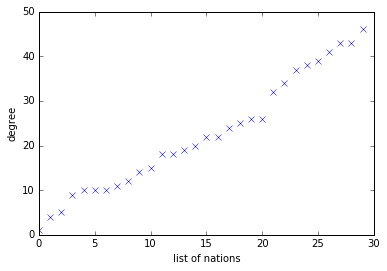

In [93]:
#degree_nn = in+out
degrees_nn = (adjm_b_nn.sum(axis=1)+adjm_b_nn.sum(axis=0)-np.diagonal(adjm_b_nn)).astype('int')
print zip(nations,degrees_nn)
plot(sorted(degrees_nn), 'bx')
xlabel('list of nations')
ylabel('degree')

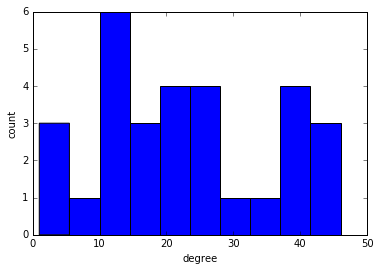

In [94]:
plt.hist(degrees_nn)
xlabel('degree')
ylabel('count')

[1, 2, 2, 3, 3, 3, 4, 4, 4, 6, 6, 6, 7, 7, 7, 7, 8, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 19, 19, 19, 19, 22, 22, 22, 23, 23, 24, 24, 25, 26, 26, 26, 26, 27, 28]


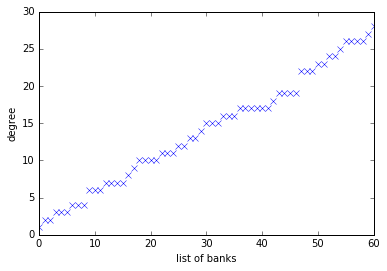

In [95]:
#banks out_degree in bipartite graph
degrees_b_banks = sorted(adjm_b_b.sum(axis=1).astype('int'))
print degrees_b_banks
plot(degrees_b_banks, 'bx')
xlabel('list of banks')
ylabel('degree')

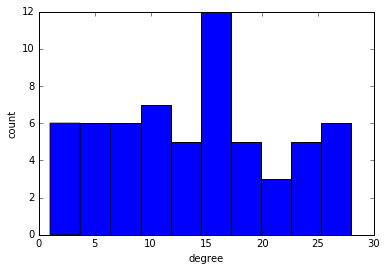

In [96]:
plt.hist(degrees_b_banks)
xlabel('degree')
ylabel('count')

[1, 6, 6, 8, 14, 15, 17, 23, 23, 24, 25, 25, 26, 27, 28, 28, 29, 32, 34, 34, 35, 36, 39, 41, 43, 45, 46, 48, 50, 51]


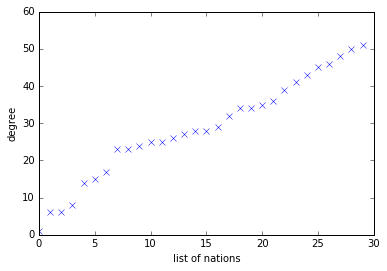

In [97]:
#nations in_degree in bipartite graph
degrees_b_nations = sorted(adjm_b_b.sum(axis=0).astype('int'))
print degrees_b_nations
plot(degrees_b_nations, 'bx')
xlabel('list of nations')
ylabel('degree')

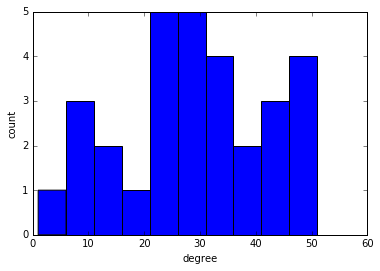

In [98]:
plt.hist(degrees_b_nations)
xlabel('degree')
ylabel('count')

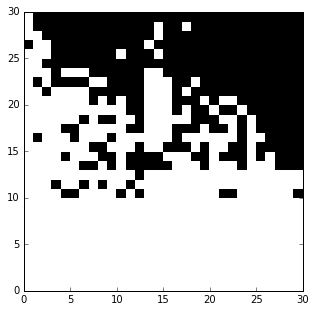

In [99]:
nu_order = argsort(degrees_nn)
sorted_adjm_b_nn = np.copy(adjm_b_nn)
sorted_adjm_b_nn = sorted_adjm_b_nn[nu_order,:]
sorted_adjm_b_nn = sorted_adjm_b_nn[:,nu_order]
figure(figsize=(5,5))
pcolormesh(sorted_adjm_b_nn, cmap=cm.binary)

{0: 0.09789155152455646, 1: 0.018515659217629665, 2: 0.0, 3: 0.004599444069887419, 4: 0.0011846117757447808, 5: 0.018556682780820715, 6: 0.0, 7: 0.011048256614759078, 8: 0.04469831618846397, 9: 0.06460800420160026, 10: 0.0022733150811968545, 11: 0.0073877613902244435, 12: 0.0, 13: 0.0033944845521200195, 14: 0.06460800420160026, 15: 0.0007215007215007215, 16: 0.0, 17: 0.0008835991594612285, 18: 0.006417563006232958, 19: 0.005942422383309083, 20: 0.028006059348423887, 21: 0.0017788724685276409, 22: 0.005477117299777399, 23: 0.00488937034503537, 24: 0.0011053806620309084, 25: 0.0009862879321007399, 26: 0.004361224435116061, 27: 0.0034451317702549234, 28: 0.032816629183624255, 29: 0.04469831618846397}


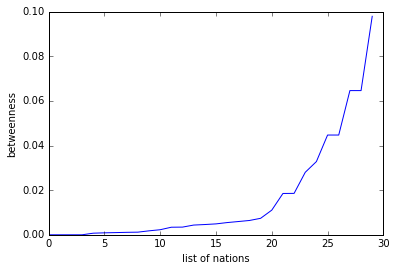

In [100]:
#now we finally use the graphs
nn_betweenness = nx.betweenness_centrality(Gnn)
print nn_betweenness
plot(sorted(nn_betweenness.values()))
xlabel('list of nations')
ylabel('betweenness')

In [103]:
#let's have a closer look
sorted([(v,nations[k]) for k,v in nx.betweenness_centrality(Gnn).items()])[::-1]

[(0.09789155152455646, u'Austria'),
 (0.06460800420160026, u'Italy'),
 (0.06460800420160026, u'Germany'),
 (0.04469831618846397, u'United Kingdom'),
 (0.04469831618846397, u'France'),
 (0.032816629183624255, u'Sweden'),
 (0.028006059348423887, u'Netherlands'),
 (0.018556682780820715, u'Denmark'),
 (0.018515659217629665, u'Belgium'),
 (0.011048256614759078, u'Finland'),
 (0.0073877613902244435, u'Hungary'),
 (0.006417563006232958, u'Luxembourg'),
 (0.005942422383309083, u'Malta'),
 (0.005477117299777399, u'Poland'),
 (0.00488937034503537, u'Portugal'),
 (0.004599444069887419, u'Cyprus'),
 (0.004361224435116061, u'Slovenia'),
 (0.0034451317702549234, u'Spain'),
 (0.0033944845521200195, u'Ireland'),
 (0.0022733150811968545, u'Greece'),
 (0.0017788724685276409, u'Norway'),
 (0.0011846117757447808, u'Czech Republic'),
 (0.0011053806620309084, u'Romania'),
 (0.0009862879321007399, u'Slovakia'),
 (0.0008835991594612285, u'Lithuania'),
 (0.0007215007215007215, u'Latvia'),
 (0.0, u'Liechtenstei

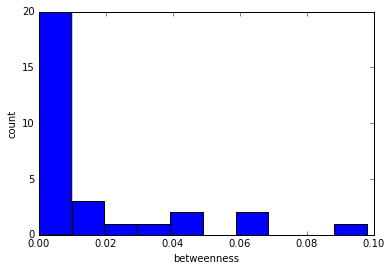

In [104]:
plt.hist(nn_betweenness.values())
xlabel('betweenness')
ylabel('count')

In [105]:
#Scatterplots!

In [106]:
nation_agg = pd.DataFrame()
nation_agg['name'] = nations
nation_agg['nn_degree'] = degrees_nn
nation_agg['nn_indegree'] = adjm_b_nn.sum(axis=0).astype('int')
nation_agg['nn_outdegree'] = adjm_b_nn.sum(axis=1).astype('int')
nation_agg['bank_indegree'] = adjm_b_b.sum(axis=0).astype('int')
nation_agg['debt'] = np.array(data.groupby('exposure')['millions'].apply(sum))
nation_agg['betweenness'] = nn_betweenness.values()
nation_agg

,name,nn_degree,nn_indegree,nn_outdegree,bank_indegree,debt,betweenness
0,Austria,41,15,27,41,42815.13,0.097892
1,Belgium,37,16,22,46,89978.57,0.018516
2,Bulgaria,9,9,0,14,1162.29,0.000000
3,Cyprus,19,7,13,15,3135.22,0.004599
4,Czech Republic,11,11,0,27,28598.32,0.001185
5,Denmark,32,13,20,25,33095.21,0.018557
6,Estonia,4,4,0,8,789.84,0.000000
7,Finland,22,14,9,36,15310.45,0.011048
8,France,43,17,27,48,192219.82,0.044698
9,Germany,46,18,29,51,469335.47,0.064608


In [107]:
banks_agg = pd.DataFrame()
banks_agg['name'] = banks
banks_agg['degree'] = adjm_b_b.sum(axis=1).astype('int')
banks_agg['owned_debt'] = np.array(data.groupby('bank')['millions'].apply(sum))
banks_agg

,name,degree,owned_debt
0,ABN AMRO BANK NV,11,18737.00
1,ALLIED IRISH BANKS PLC,12,7943.93
2,BANCA MONTE DEI PASCHI DI SIENA S.p.A,16,30671.93
3,BANCO BILBAO VIZCAYA ARGENTARIA S.A. (BBVA),15,61496.44
4,"BANCO COMERCIAL PORTUGUÊS, SA (BCP OR MILLENNI...",10,6081.78
5,BANCO POPOLARE - S.C.,2,15590.00
6,"BANCO POPULAR ESPAÑOL, S.A.",3,15600.19
7,BANCO SANTANDER S.A.,11,71769.61
8,BANK OF CYPRUS PUBLIC CO LTD,12,1933.23
9,BANK OF IRELAND,6,6458.00


In [119]:
def scatterplot(x,y,l):
    figure(figsize=(15,15))
    plt.scatter(x,y)
    for i,label in enumerate(l):
        plt.text(x[i],y[i],label)

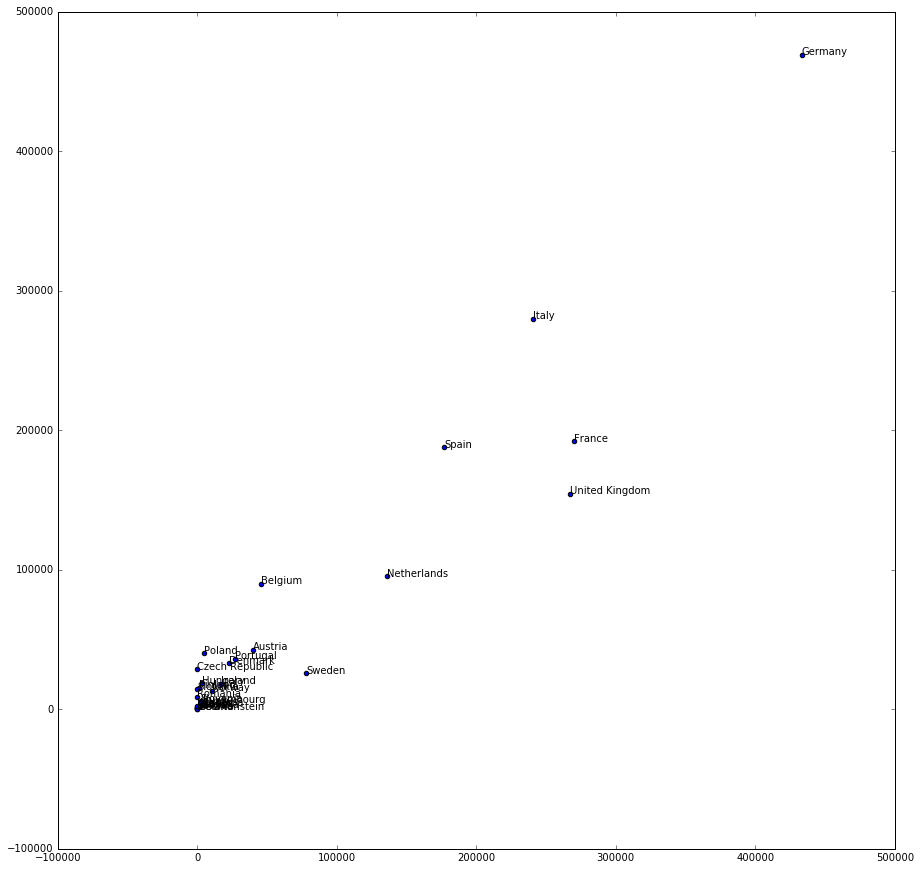

In [120]:
scatterplot(adjm_w_nn.sum(axis=1),adjm_w_nn.sum(axis=0),nations)

In [121]:
banks_agg.head()

,name,degree,owned_debt
0,ABN AMRO BANK NV,11,18737.00
1,ALLIED IRISH BANKS PLC,12,7943.93
2,BANCA MONTE DEI PASCHI DI SIENA S.p.A,16,30671.93
3,BANCO BILBAO VIZCAYA ARGENTARIA S.A. (BBVA),15,61496.44
4,"BANCO COMERCIAL PORTUGUÊS, SA (BCP OR MILLENNI...",10,6081.78


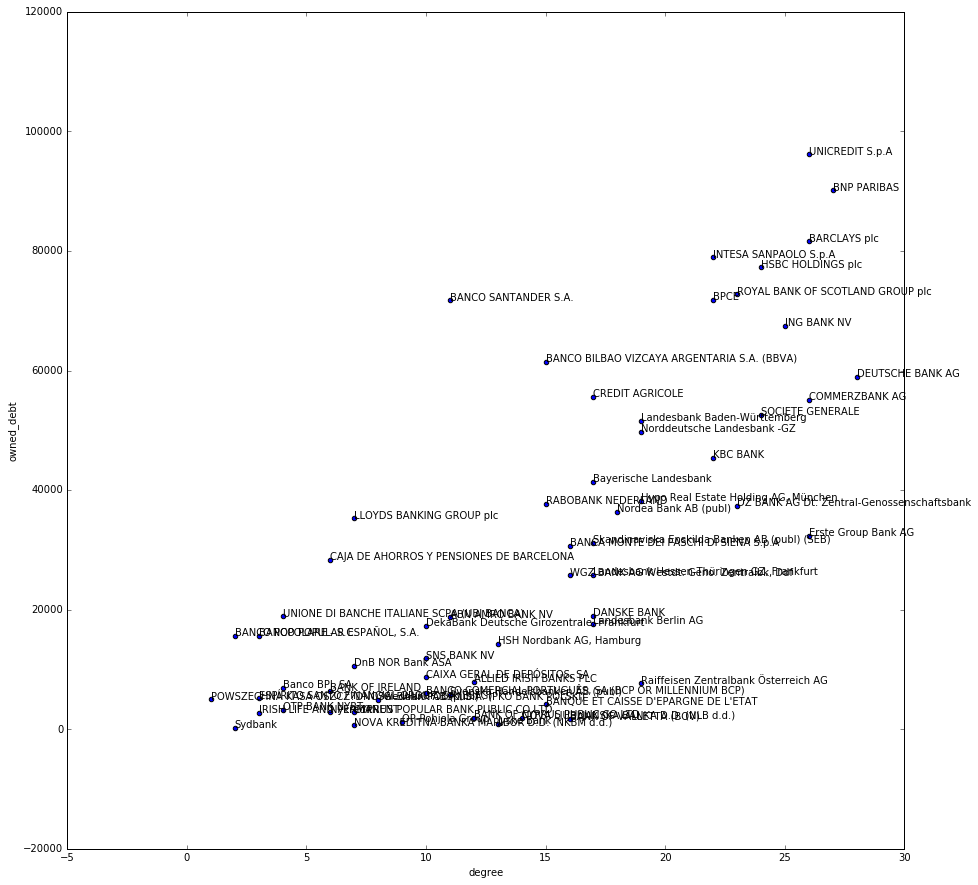

In [122]:
scatterplot(banks_agg['degree'],banks_agg['owned_debt'],banks)
xlabel('degree')
ylabel('owned_debt')

In [ ]:
nation_agg.head()

In [ ]:
scatterplot(nation_agg['debt'],nation_agg['bank_indegree'],nations)
xlabel('debt')
ylabel('bank_indegree')

# Community Detection

In [ ]:
import community
c = community.best_partition(Gnn)

In [ ]:
['red','blue']

In [ ]:
import community
c = community.best_partition(Gnn)
colors = ['red','blue','green','cyan']
nx.draw(Gnn,
        pos=nx.fruchterman_reingold_layout(Gnn), 
        cmap=plt.cm.hsv,
        node_color=[colors[i] for i in [c[node] for node in Gnn.nodes()]])

In [ ]:
clustered_nations = [n for (v,n) in sorted([(v,nations[k]) for (k,v) in c.items()])]
nu_order = argsort(argsort(clustered_nations))
sorted_adjm_b_nn = np.copy(adjm_b_nn)
sorted_adjm_b_nn = sorted_adjm_b_nn[nu_order,:]
sorted_adjm_b_nn = sorted_adjm_b_nn[:,nu_order]
figure(figsize=(5,5))
pcolormesh(sorted_adjm_b_nn, cmap=cm.binary)

# Graph-Viz, part 2

In [147]:
G_nn_exp = nx.DiGraph()
for i in range(adjm_w_nn.shape[0]):
    for j in range(adjm_w_nn.shape[1]):
        if adjm_w_nn[i,j]>0:
            #print nations[i],nations[j],adjm_w_nn[i,j]
            G_nn_exp.add_edge(nations[i],nations[j],weight=adjm_w_nn[i,j])
nx.write_gml(G_nn_exp,'graph_nn.gml')

G_b_exp = nx.DiGraph()
for k in banks:
    G_b_exp.add_node(k,bipartite='bank')
for k in nations:
    G_b_exp.add_node(k,bipartite='nation')
for i in range(adjm_w_b.shape[0]):
    for j in range(adjm_w_b.shape[1]):
        if adjm_w_b[i,j]>0:
            #print banks[i],nations[j],adjm_w_b[i,j]
            G_b_exp.add_edge(banks[i],nations[j],weight=adjm_w_b[i,j])
nx.write_gml(G_b_exp,'graph_b_bip.gml')

In [ ]:
#to gephi!